# Exemple to get started!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import os
import pickle
import codecs
import re
from tqdm import tqdm_notebook as tqdm

#For tokenizing sentences
import nltk
nltk.download('punkt')
plt.style.use('seaborn-whitegrid')

# Cte
BASE_PATH = "data/"

### Reading the data

In [2]:
statements_df = pd.read_csv(f"{BASE_PATH}dataset/FOMC/statement.csv")

Preprocess the data ...

In [3]:
# Text clean up
statements_df['text'] = statements_df['contents'].apply(lambda x: x.replace('\n\n[SECTION]\n\n', '').replace('\n', ' ').replace('\r', ' ').strip())
statements_df.drop(columns=['title'], axis=1, inplace=True)

statements_df.head()

,Unnamed: 0,date,contents,speaker,text
0,0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...
1,1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...
2,2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...
3,3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today ann...,Alan Greenspan,The Federal Reserve today announced two action...
4,4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced...,Alan Greenspan,The Federal Reserve announced today the follow...


In [4]:
print('Date: ', datetime.strptime(statements_df.iloc[-1]['date'], '%Y-%m-%d'))
print('Speaker: ', statements_df.iloc[-1]['speaker'])
print('Text: \n\n', statements_df.iloc[-1]['contents'].replace('\n[SECTION]\n', '')[1192:])

Date:  2022-11-02 00:00:00
Speaker:  other
Text: 

 ysis

Consumer Resources

November 02, 2022

For release at 2:00 p.m. EDT                     
                
                

Share

Recent indicators point to modest growth in spending and production. Job gains have been robust in recent months, and the unemployment rate has remained low. Inflation remains elevated, reflecting supply and demand imbalances related to the pandemic, higher food and energy prices, and broader price pressures.

Russia's war against Ukraine is causing tremendous human and economic hardship. The war and related events are creating additional upward pressure on inflation and are weighing on global economic activity. The Committee is highly attentive to inflation risks.

The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. In support of these goals, the Committee decided to raise the target range for the federal funds rate to 3-3/4 to 4 percent. The

# Divide the data into a training set and a test set before continuing the analysis.

In [5]:
from utils.Split import split_and_save

statements_df, statements_df_test = split_and_save(statements_df, date_split='2022-05-01', filename_prefix='statement', output_path='')

# Now let's extract a basic textual analysis of the statements.

### Creating a Financial Dictionary based on Loughran and McDonald

In [6]:
from utils.MasterDictionary import load_masterdictionary

lm_dict_path = (f'{BASE_PATH}dataset/dictionnaries/LoughranMcDonald/Loughran-McDonald_MasterDictionary_1993-2021.csv')
master_dictionaries, md_header, sentiment_categories, sentiment_dictionaries, stopwords, total_documents = \
    load_masterdictionary(lm_dict_path, True, None, True)


 ...Loading Master Dictionary 85,000
Master Dictionary loaded from file:
  data/dataset/dictionnaries/LoughranMcDonald/Loughran-McDonald_MasterDictionary_1993-2021.csv

  master_dictionary has 86,531 words.



In [7]:
import re

lmdict = {'Negative': [word.lower() for word in master_dictionaries.keys() if master_dictionaries[word].negative], 
          'Positive': [word.lower() for word in master_dictionaries.keys() if master_dictionaries[word].positive]}

negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

print(f"Number of positive word: {len(lmdict['Positive'])}")
print(f"Number of negative word: {len(lmdict['Negative'])}")

Number of positive word: 354
Number of negative word: 2355


In [8]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

In [9]:
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

In [10]:
Data = statements_df
print(len(Data))
temp = [tone_count_with_negation_check(lmdict,x) for x in Data.text]
temp = pd.DataFrame(temp)

Data['wordcount'] = temp.iloc[:,0].values
Data['NPositiveWords'] = temp.iloc[:,1].values
Data['NNegativeWords'] = temp.iloc[:,2].values

#Sentiment Score normalized by the number of words
Data['sentiment'] = (Data['NPositiveWords'] - Data['NNegativeWords']) / Data['wordcount'] * 100

Data['Poswords'] = temp.iloc[:,3].values
Data['Negwords'] = temp.iloc[:,4].values


196


In [11]:
temp.tail()

,0,1,2,3,4
191,621,18,6,"[stable, stability, stability, stability, prog...","[challenging, adversely, slowed, crisis, persi..."
192,727,16,7,"[stable, stability, stability, stability, prog...","[challenging, adversely, slowed, imbalances, e..."
193,638,15,7,"[stable, stability, stability, stability, prog...","[challenging, adversely, unemployment, decline..."
194,547,12,6,"[stable, stability, stability, strengthen, imp...","[adversely, unemployment, declined, imbalances..."
195,465,10,6,"[stable, stability, stability, strengthen, gai...","[unemployment, declined, imbalances, hardship,..."


In [12]:
Data.tail()

,Unnamed: 0,date,contents,speaker,text,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords
191,191,2021-09-22,"The Federal Reserve, the central bank of the U...",Jerome Powell,"The Federal Reserve, the central bank of the U...",621,18,6,1.932367,"[stable, stability, stability, stability, prog...","[challenging, adversely, slowed, crisis, persi..."
192,192,2021-11-03,"The Federal Reserve, the central bank of the U...",Jerome Powell,"The Federal Reserve, the central bank of the U...",727,16,7,1.237964,"[stable, stability, stability, stability, prog...","[challenging, adversely, slowed, imbalances, e..."
193,193,2021-12-15,"The Federal Reserve, the central bank of the U...",Jerome Powell,"The Federal Reserve, the central bank of the U...",638,15,7,1.253918,"[stable, stability, stability, stability, prog...","[challenging, adversely, unemployment, decline..."
194,194,2022-01-26,"The Federal Reserve, the central bank of the U...",other,"The Federal Reserve, the central bank of the U...",547,12,6,1.096892,"[stable, stability, stability, strengthen, imp...","[adversely, unemployment, declined, imbalances..."
195,195,2022-03-16,"The Federal Reserve, the central bank of the U...",other,"The Federal Reserve, the central bank of the U...",465,10,6,0.860215,"[stable, stability, stability, strengthen, gai...","[unemployment, declined, imbalances, hardship,..."


### Plots of the sentiment analysis

Plot positive and negative word counts

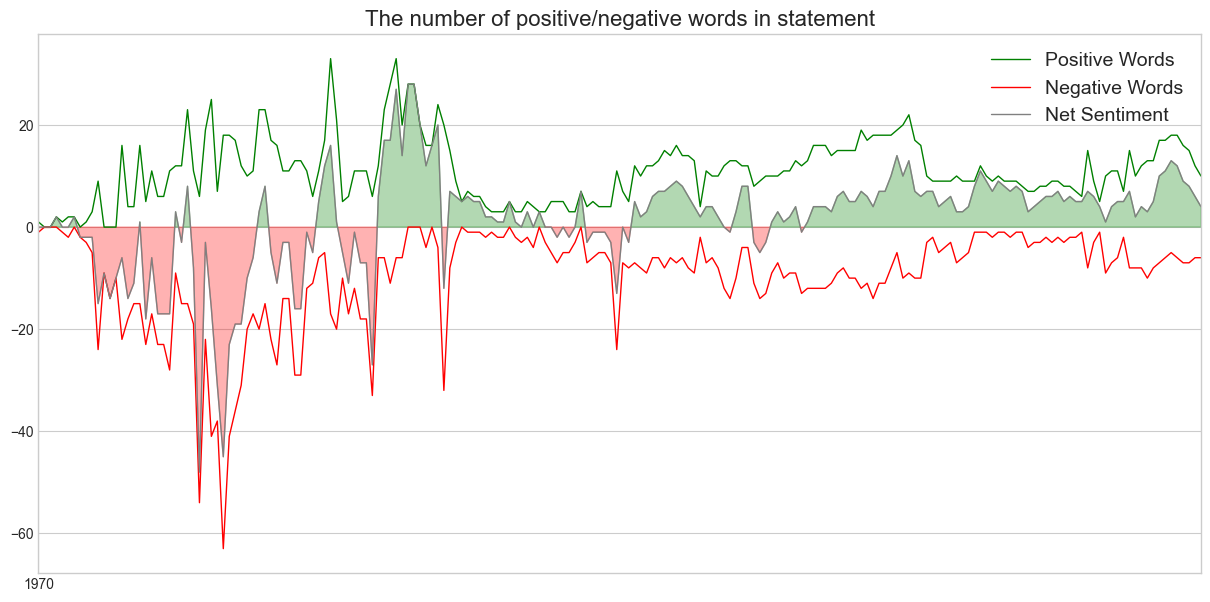

In [13]:
NetSentiment = Data['NPositiveWords'] - Data['NNegativeWords']

plt.figure(figsize=(15,7))
ax = plt.subplot()

plt.plot(Data.index, Data['NPositiveWords'], c='green', linewidth= 1.0)
plt.plot(Data.index, Data['NNegativeWords']*-1, c='red', linewidth=1.0)
plt.plot(Data.index, NetSentiment, c='grey', linewidth=1.0)

plt.title('The number of positive/negative words in statement', fontsize=16)
plt.legend(['Positive Words', 'Negative Words', 'Net Sentiment'], prop={'size': 14}, loc=1)

ax.fill_between(Data.index, NetSentiment, where=(NetSentiment > 0), color='green', alpha=0.3, interpolate=True)
ax.fill_between(Data.index, NetSentiment, where=(NetSentiment <= 0), color='red', alpha=0.3, interpolate=True)

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
datemin = Data.index[0]
datemax = Data.index[-1]

ax.set_xlim(datemin, datemax)

ax.grid(True)

plt.show()

In [14]:
# Now it's your turn to continue, you are free to throw away the previous analysis and start on a better basis
...

Now that you know how to start the sentiment analysis process, let's jump ahead a bit and see how to produce an evaluation metric for the part 3

### Example of prediction

Let's forecast the May 2022 using the average of the last three week. 
-> This won't be good, but it's a basic exemple

In [15]:
# Read the data
df = pd.read_csv("data/dataset/FXUSDCAD.csv")

# Split the data
date_split='2022-05-01'
train, test = split_and_save(df, date_split=date_split, filename_prefix="FXUSDCAD")

print(f"First date: {test.iloc[0].date} \n Last date: {test.iloc[-1].date} ")
test.head()

First date: 2022-05-02 00:00:00 
 Last date: 2022-11-03 00:00:00 


,date,FXUSDCAD
1331,2022-05-02,1.2895
1332,2022-05-03,1.2847
1333,2022-05-04,1.2810
1334,2022-05-05,1.2822
1335,2022-05-06,1.2882


In [16]:
from datetime import datetime
from datetime import timedelta

# Reset all exchange rate value
pred = test.copy(deep=True)
pred["FXUSDCAD"] = np.nan
pred['date'] = pd.to_datetime(pred['date'], format='%Y-%m-%d')

# Take the mean as a dummy prediction for the exemple
train_mean = train.loc[(df['date'] >= '2022-01-01') & (df['date'] < date_split)].FXUSDCAD.mean()

# Make a dummy prediction for every two week
pred_date = pd.to_datetime(test.iloc[0].date, format='%Y-%m-%d')
while datetime.today() > pred_date:
    pred.loc[pred["date"]==pred_date, "FXUSDCAD"] = train_mean
    pred_date += timedelta(days=14)

# Remove value not predicted
pred.dropna(inplace=True)

Let's evaluate the results

In [17]:
from utils.Evaluate import evaluate

mse = evaluate(pred, "data/test/FXUSDCAD.csv")

 Mean squared error: 0.003172293275522813


Let's export the results

In [18]:
# Export the results as a file
pred.to_csv("data/result/prediction.csv", index=False)

# Now it's your turn! Good luck & Enjoy :)